In [119]:
#IMPORTING SOME LIBRARY

import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
from collections import defaultdict
import warnings
import time
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import json
import requests

from datetime import datetime, date, timedelta

In [121]:
#Config chart

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'

In [122]:
stock = "ETHUSDT"
def get_data(stock):
    url = f"https://api.binance.com/api/v3/klines?symbol={stock}&interval=1h"
    r = requests.get(url)
    klines = np.array(r.json())
    return klines

In [123]:
def binance_to_df(klines):
    df = pd.DataFrame(klines.reshape(-1,12),dtype=float, columns = ('t',
                                                                    'o',
                                                                    'h',
                                                                    'l',
                                                                    'c',
                                                                    'v',
                                                                    'Close time',
                                                                    'Quote asset volume',
                                                                    'Number of trades',
                                                                    'Taker buy base asset volume',
                                                                    'Taker buy quote asset volume',
                                                                    'Ignore'))

    df['t'] = pd.to_datetime(df['t'], unit='ms')


    return df

prices = binance_to_df(klines)
prices.head()

,t,o,h,l,c,v,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2021-04-26 01:41:00,2444.33,2452.73,2443.09,2451.20,3210.70997,1.619401e+12,7.862197e+06,4235.0,2483.46183,6.081274e+06,0.0
1,2021-04-26 01:42:00,2451.21,2452.52,2441.72,2442.59,1791.75224,1.619401e+12,4.383918e+06,2851.0,958.26714,2.344999e+06,0.0
2,2021-04-26 01:43:00,2443.06,2449.66,2442.99,2449.59,1538.07856,1.619401e+12,3.761725e+06,2076.0,796.92056,1.949113e+06,0.0
3,2021-04-26 01:44:00,2449.67,2449.95,2437.56,2440.52,4896.05078,1.619401e+12,1.195655e+07,2954.0,3101.34964,7.570923e+06,0.0
4,2021-04-26 01:45:00,2440.71,2447.91,2438.76,2445.23,2125.43105,1.619402e+12,5.188492e+06,1942.0,1484.38716,3.622438e+06,0.0


In [124]:
def resample(data, rate):
    data = data.resample(rate, on='t',closed='right', label='right').agg({'o': 'first',
                                                                                                 'h': 'max',
                                                                                                 'l': 'min',
                                                                                                 'c': 'last'}).dropna()
    return data
resampled_prices = resample(prices, '1T')
resampled_prices


,o,h,l,c
t,,,,
2021-04-26 01:41:00,2444.33,2452.73,2443.09,2451.20
2021-04-26 01:42:00,2451.21,2452.52,2441.72,2442.59
2021-04-26 01:43:00,2443.06,2449.66,2442.99,2449.59
2021-04-26 01:44:00,2449.67,2449.95,2437.56,2440.52
2021-04-26 01:45:00,2440.71,2447.91,2438.76,2445.23
...,...,...,...,...
2021-04-26 09:56:00,2479.70,2481.89,2477.91,2478.86
2021-04-26 09:57:00,2478.86,2479.00,2475.00,2478.05
2021-04-26 09:58:00,2478.05,2480.00,2476.89,2478.73


In [126]:
def get_max_min(prices, smoothing, window_range):
    smooth_prices = prices['c'].rolling(window=smoothing).mean().dropna()
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    price_local_max_dt = []
    for i in local_max:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_max_dt.append(prices.iloc[i-window_range:i+window_range]['c'].idxmax())
    price_local_min_dt = []
    for i in local_min:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_min_dt.append(prices.iloc[i-window_range:i+window_range]['c'].idxmin())  
    maxima = pd.DataFrame(prices.loc[price_local_max_dt])
    minima = pd.DataFrame(prices.loc[price_local_min_dt])
    max_min = pd.concat([maxima, minima]).sort_index()
    max_min.index.name = 'date'
    max_min = max_min.reset_index()
    max_min = max_min[~max_min.date.duplicated()]
    p = prices.reset_index()   
    max_min['day_num'] = p[p['t'].isin(max_min.date)].index.values
    max_min = max_min.set_index('day_num')['c']
    return max_min

min_max = get_max_min(resampled_prices, 3, 3)
min_max



day_num
6      2433.47
7      2434.99
9      2454.53
15     2453.87
18     2446.95
        ...   
468    2425.77
476    2438.39
477    2443.03
493    2484.30
496    2478.05
Name: c, Length: 118, dtype: float64

# Patterns 

## What Is an ABCD Pattern?

* Reflects the common, rhythmic style in which the market moves.
* A visual, geometric price/time pattern comprised of 3 consecutive price swings, or trends—it looks like a lightning bolt on price chart.
* A leading indicator that helps determine where & when to enter and exit a trade.

https://www.forex.com/en/education/education-themes/technical-analysis/abcd-pattern/


## How to find Patterns
https://optionstrategiesinsider.com/blog/17-stock-chart-patterns-to-look-for-when-analyzing-stocks/

| Patterns  | Name  | Condition  | Links |
| :- | :- | :- | :- |
| IHS | Inverse Head and Shoulders | B > A > C; D > E > C    | https://optionstrategiesinsider.com/blog/inverse-head-and-shoulders-pattern/ |
| DT | Double Top | A < C < B; D > C > E  | https://optionstrategiesinsider.com/blog/double-top-pattern/|


We just use IHS as an example


In [127]:
def find_patterns(max_min):  
    patterns = defaultdict(list)
    
    for i in range(5, len(max_min)):  
        window = max_min.iloc[i-5:i]
        
        # Pattern must play out in less than n units
        if window.index[-1] - window.index[0] > 100:      
            continue   

        a, b, c, d, e = window.iloc[0:5]
        #https://www.forex.com/en/education/education-themes/technical-analysis/abcd-pattern/        
        # IHS
        if a<b and c<a and c<e and c<d and e<d and abs(b-d)<=np.mean([b,d])*0.02:
              patterns['IHS'].append((window.index[0], window.index[-1]))
        
    return patterns
patterns = find_patterns(min_max)
print(patterns['IHS'])

[(88, 102), (126, 143), (143, 158), (198, 218), (242, 262), (311, 329), (383, 399)]


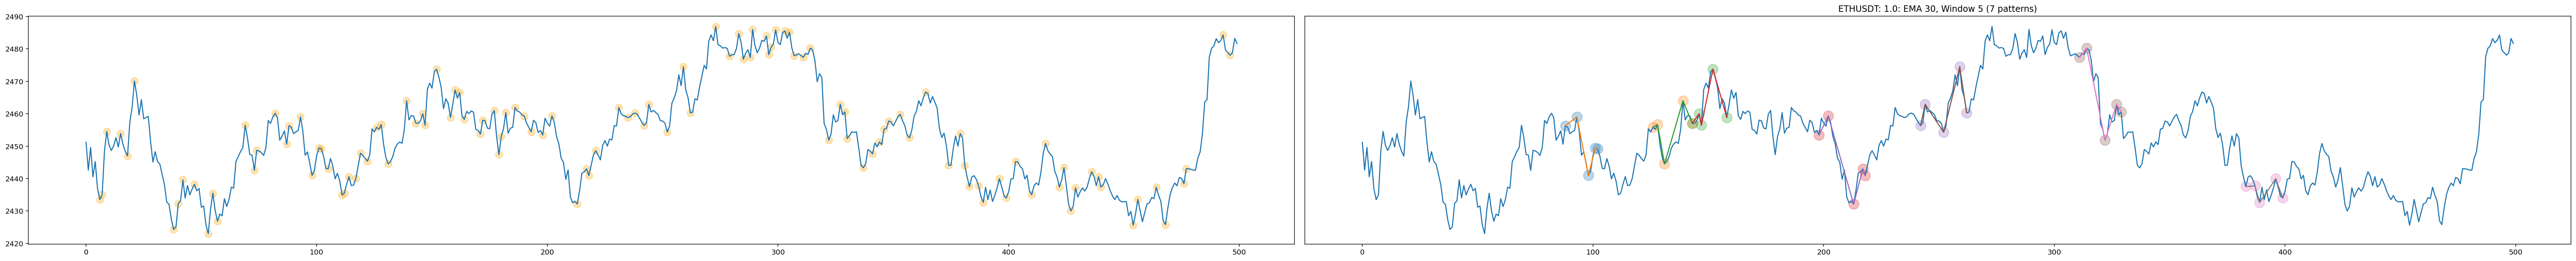

In [134]:
def plot_minmax_patterns(prices, max_min, patterns, stock, window, ema):
    
    incr = str((prices.index[1] - prices.index[0]).seconds/60)
    
    if len(patterns) == 0:
        pass
    else:
        num_pat = len([x for x in patterns.items()][0][1])
        f, axes = plt.subplots(1, 2, figsize=(50, 5))
        axes = axes.flatten()
        prices_ = prices.reset_index()['c']
        axes[0].plot(prices_)
        axes[0].scatter(max_min.index, max_min, s=100, alpha=.3, color='orange')
        axes[1].plot(prices_)
        for name, end_day_nums in patterns.items():
            for i, tup in enumerate(end_day_nums):
                sd = tup[0]
                ed = tup[1]
                #axes[1].scatter(max_min.loc[sd:ed].index,
                #              max_min.loc[sd:ed].values,
                #              s=200, alpha=.3)
                axes[1].plot(max_min.loc[sd:ed].index,
                              max_min.loc[sd:ed].values)
                plt.yticks([])
        plt.tight_layout()
        plt.title('{}: {}: EMA {}, Window {} ({} patterns)'.format(stock, incr, ema, window, num_pat))
        


plot_minmax_patterns(resampled_prices, min_max, patterns, stock, 5, 30)

In [115]:
def get_results(prices, max_min, pat, stock, ema_, window_):
    
    incr = str((prices.index[1] - prices.index[0]).seconds/60)
    
    fw_list = [1, 12, 24, 36] 
    #fw_list = [1, 2, 3]
    results = []
    if len(pat.items()) > 0:
        end_dates = [v for k, v in pat.items()][0]      
        for date in end_dates:  
            param_res = {'stock': stock,
                         'increment': incr,
                         'ema': ema_,
                         'window': window_, 
                         'date': date}
            for x in fw_list:
                returns = (prices['c'].pct_change(x).shift(-x).reset_index(drop=True).dropna())
                try:
                    param_res['fw_ret_{}'.format(x)] = returns.loc[date[1]]   
                except Exception as e:
                    param_res['fw_ret_{}'.format(x)] = e
            results.append(param_res)  
    else:
        param_res = {'stock': stock,
                     'increment': incr,
                     'ema': ema_,
                     'window': window_,
                     'date': None}
        for x in fw_list:
            param_res['fw_ret_{}'.format(x)] = None   
        results.append(param_res)
    return pd.DataFrame(results)

In [116]:
def screener(prices, ema_list, window_list, plot, results):
    
    all_results = pd.DataFrame()
    for ema_ in ema_list:
        for window_ in window_list: 
            print(f"stock ==== {stock} EMA === {ema_} WINDOW ==== {window_}. PLOT === {plot}")
            max_min = get_max_min(prices, smoothing=ema_, window_range=window_)
            pat = find_patterns(max_min)
            if plot == True:
                print('Plotting -------------------------------------')
                plot_minmax_patterns(prices, max_min, pat, stock, window_, ema_)       
            if results == True:
                all_results = pd.concat([all_results, get_results(prices, max_min, pat, stock, ema_, window_)], axis=0)
                
    if results == True:
        return all_results.reset_index(drop=True)

stock ==== ETHUSDT EMA === 3 WINDOW ==== 3. PLOT === True
Plotting -------------------------------------
stock ==== ETHUSDT EMA === 3 WINDOW ==== 10. PLOT === True
Plotting -------------------------------------
stock ==== ETHUSDT EMA === 3 WINDOW ==== 20. PLOT === True
Plotting -------------------------------------
stock ==== ETHUSDT EMA === 3 WINDOW ==== 30. PLOT === True
Plotting -------------------------------------
stock ==== ETHUSDT EMA === 10 WINDOW ==== 3. PLOT === True
Plotting -------------------------------------
stock ==== ETHUSDT EMA === 10 WINDOW ==== 10. PLOT === True
Plotting -------------------------------------
stock ==== ETHUSDT EMA === 10 WINDOW ==== 20. PLOT === True
Plotting -------------------------------------
stock ==== ETHUSDT EMA === 10 WINDOW ==== 30. PLOT === True
Plotting -------------------------------------
stock ==== ETHUSDT EMA === 20 WINDOW ==== 3. PLOT === True
Plotting -------------------------------------
stock ==== ETHUSDT EMA === 20 WINDOW ==== 10

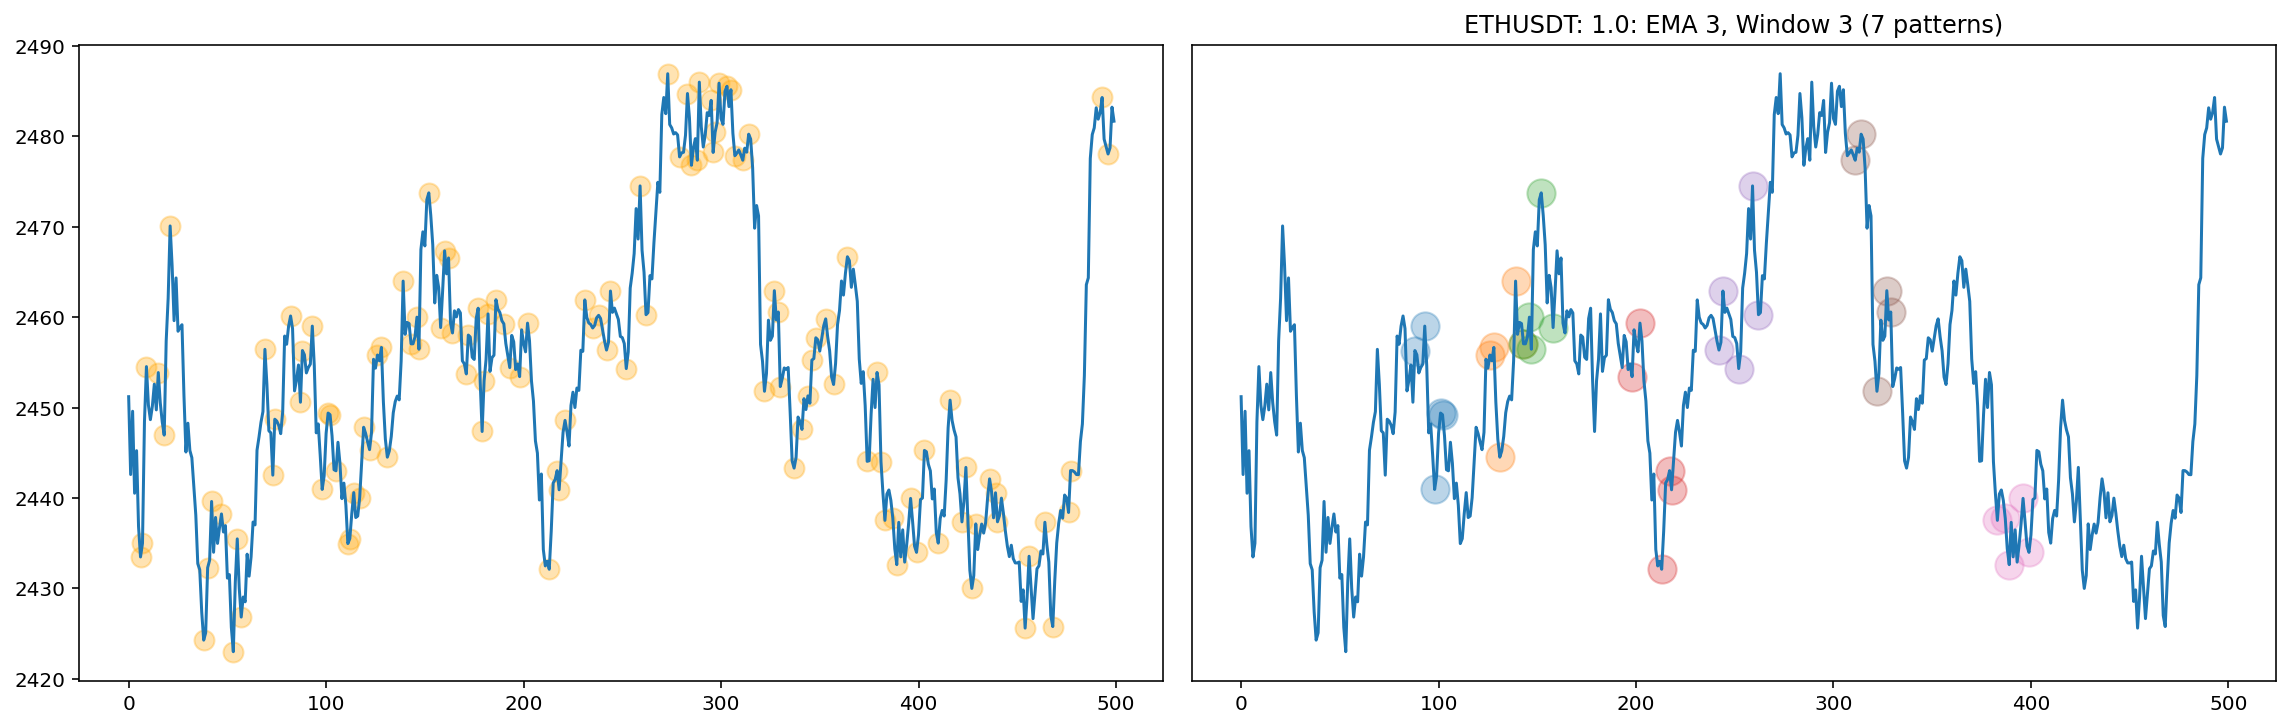

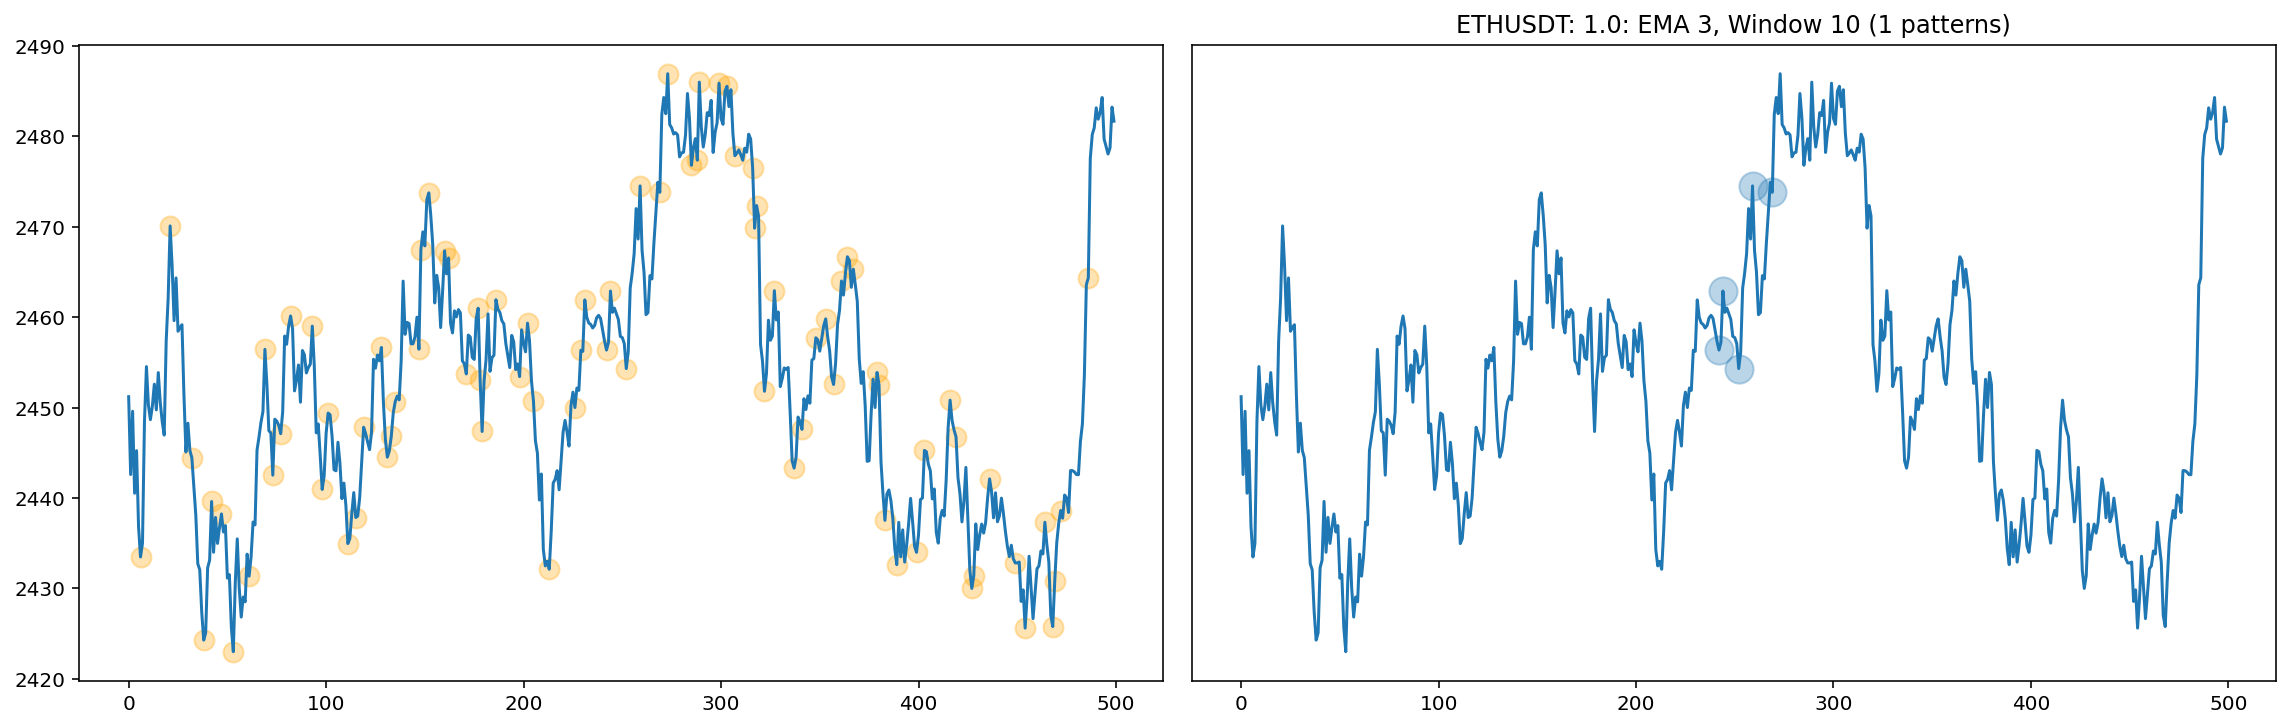

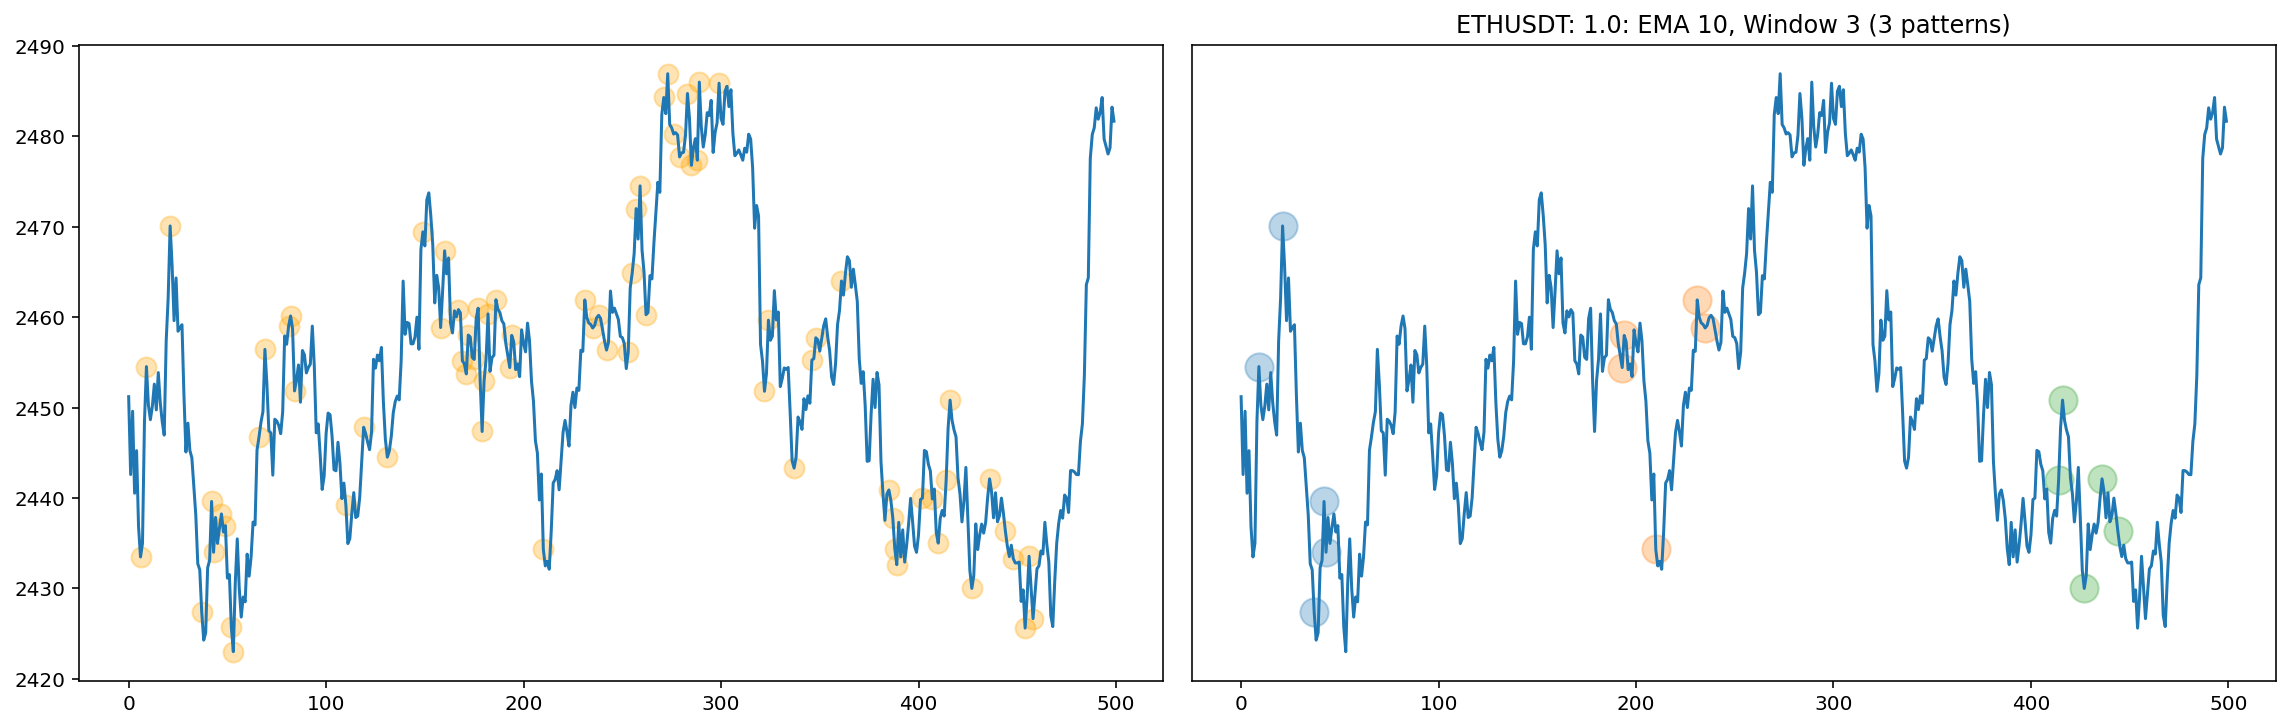

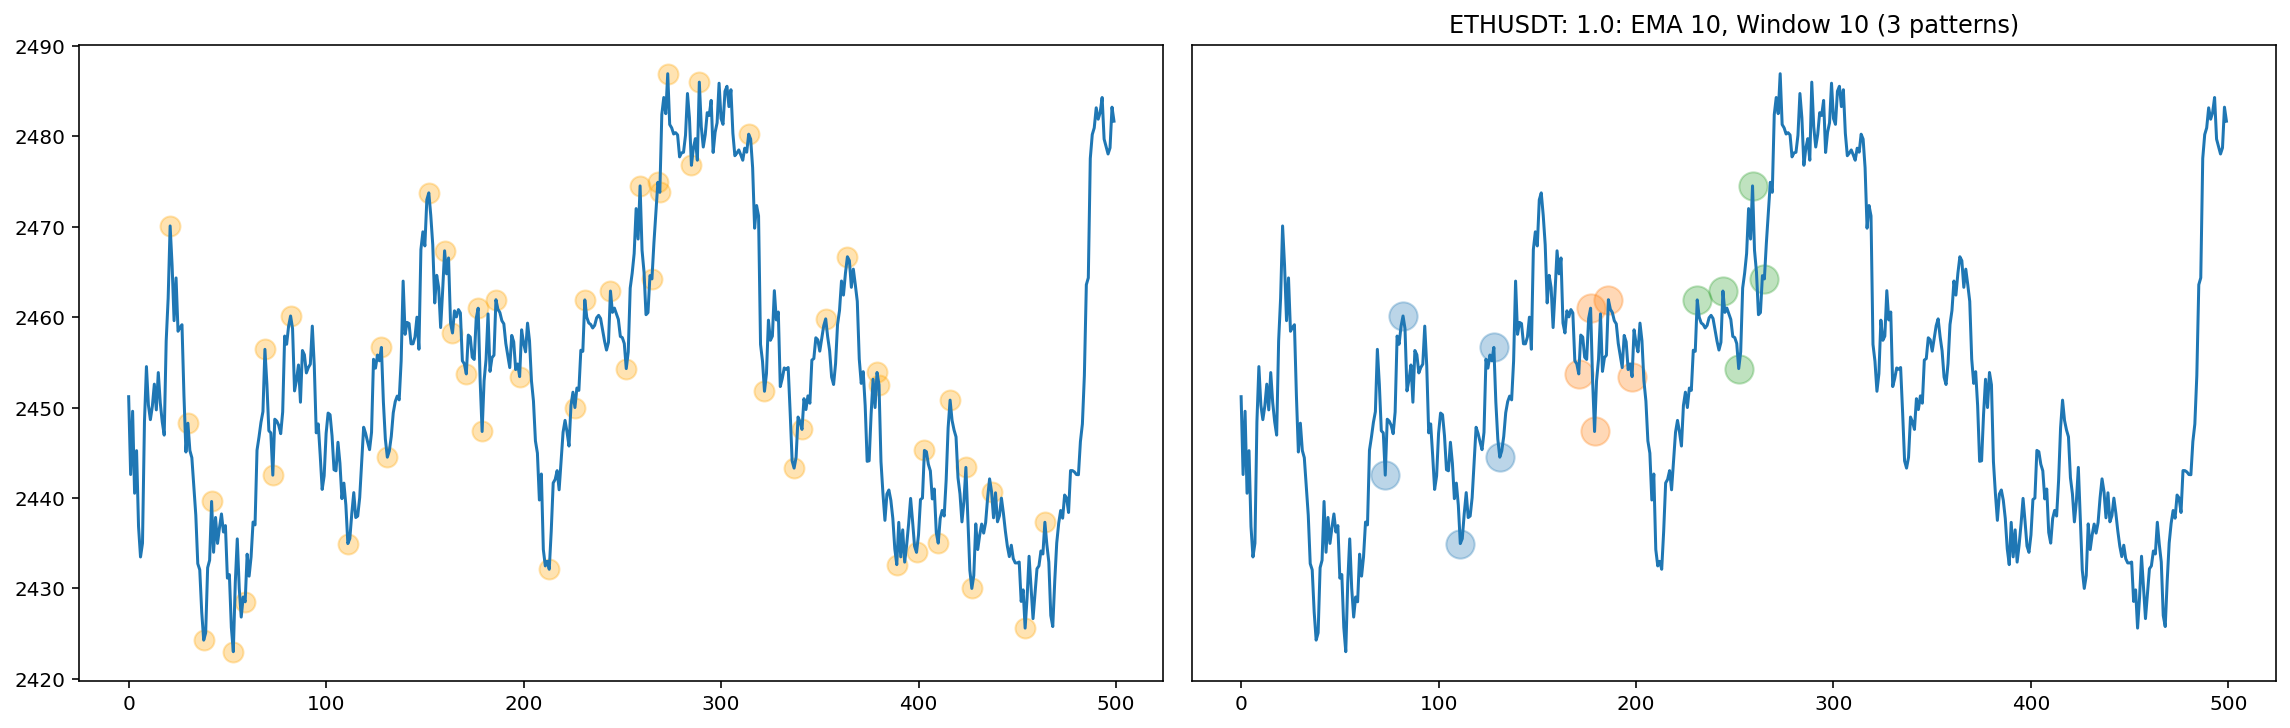

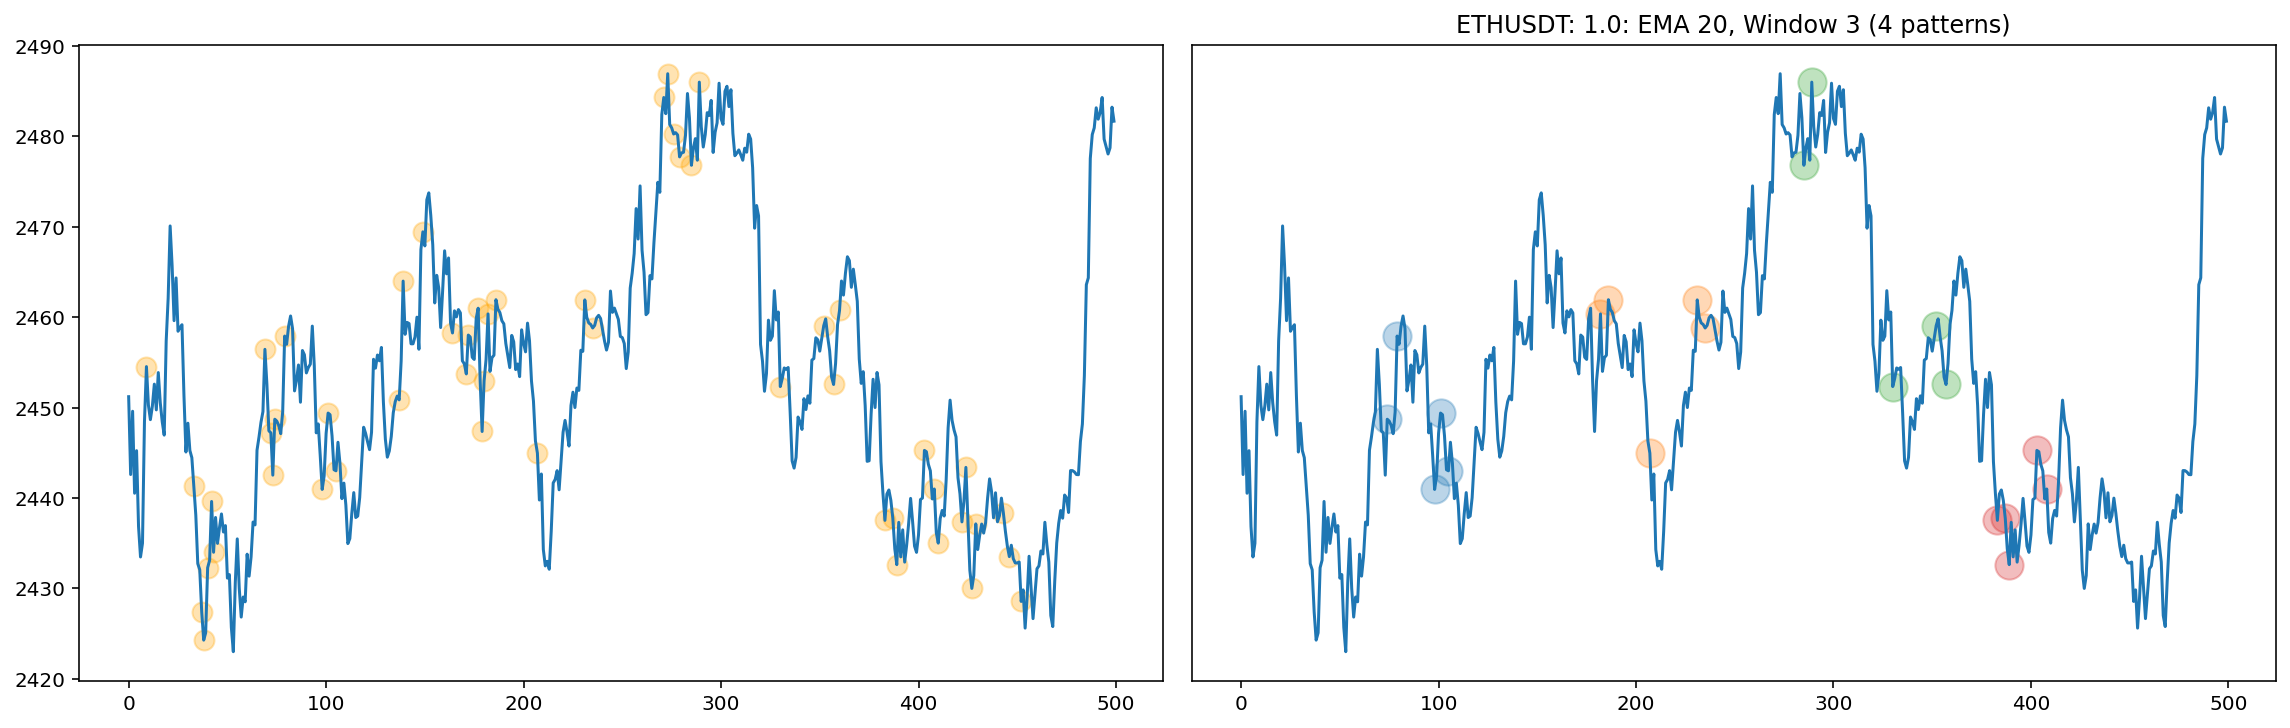

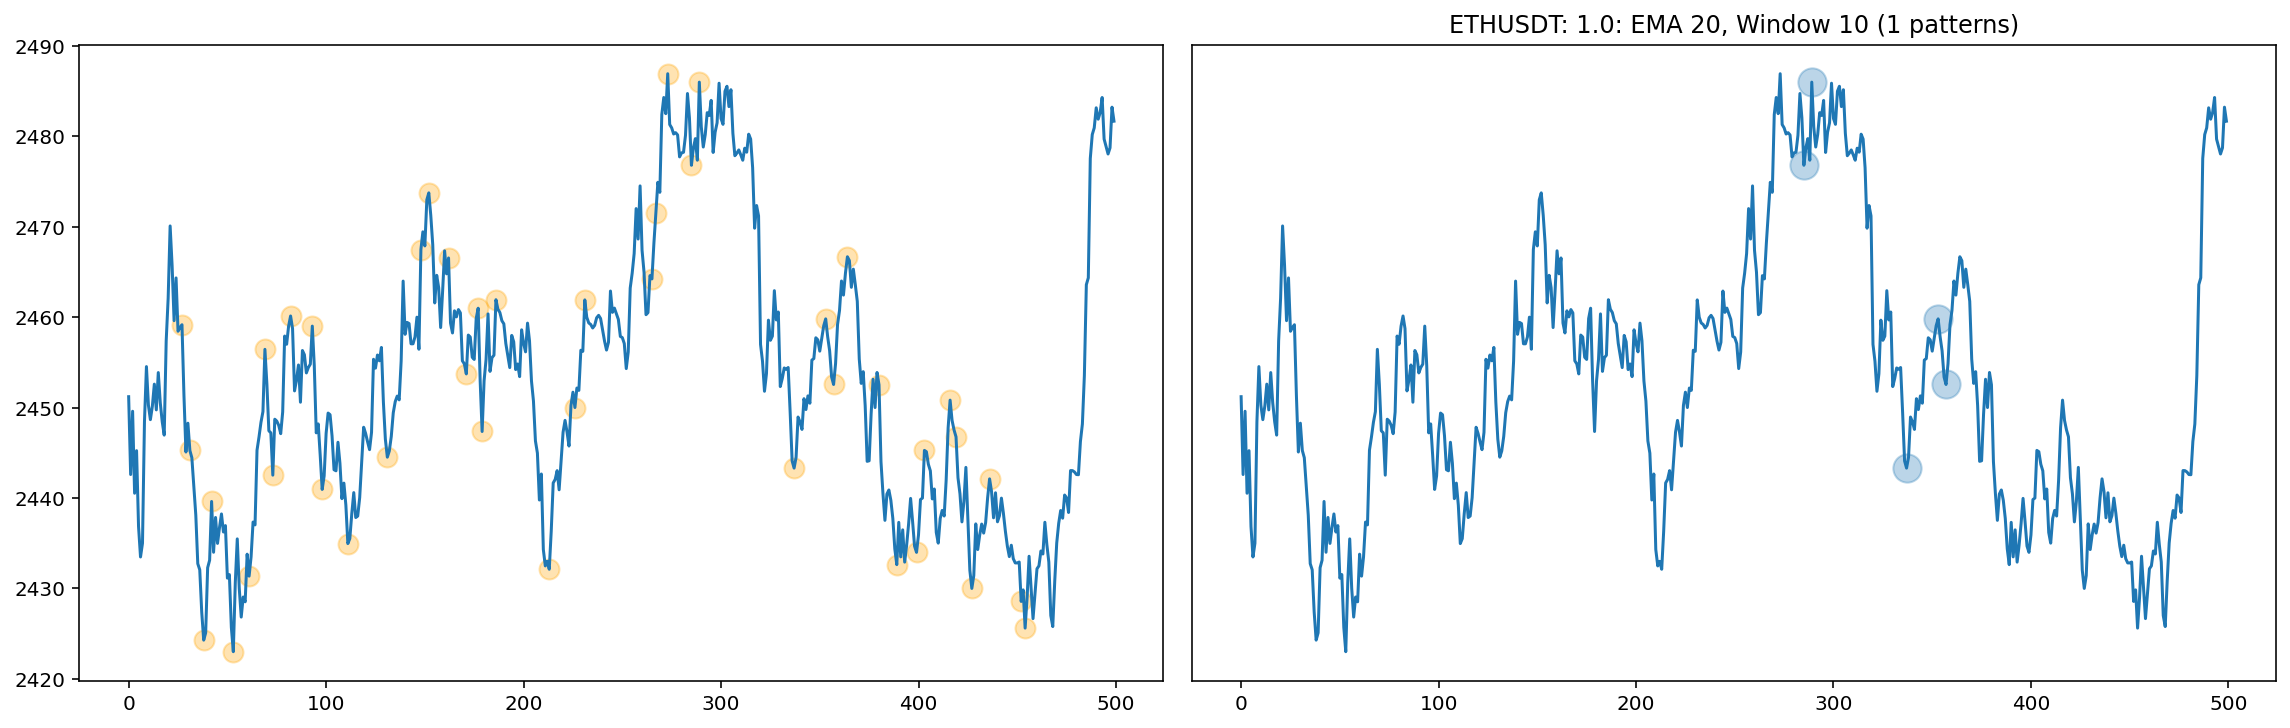

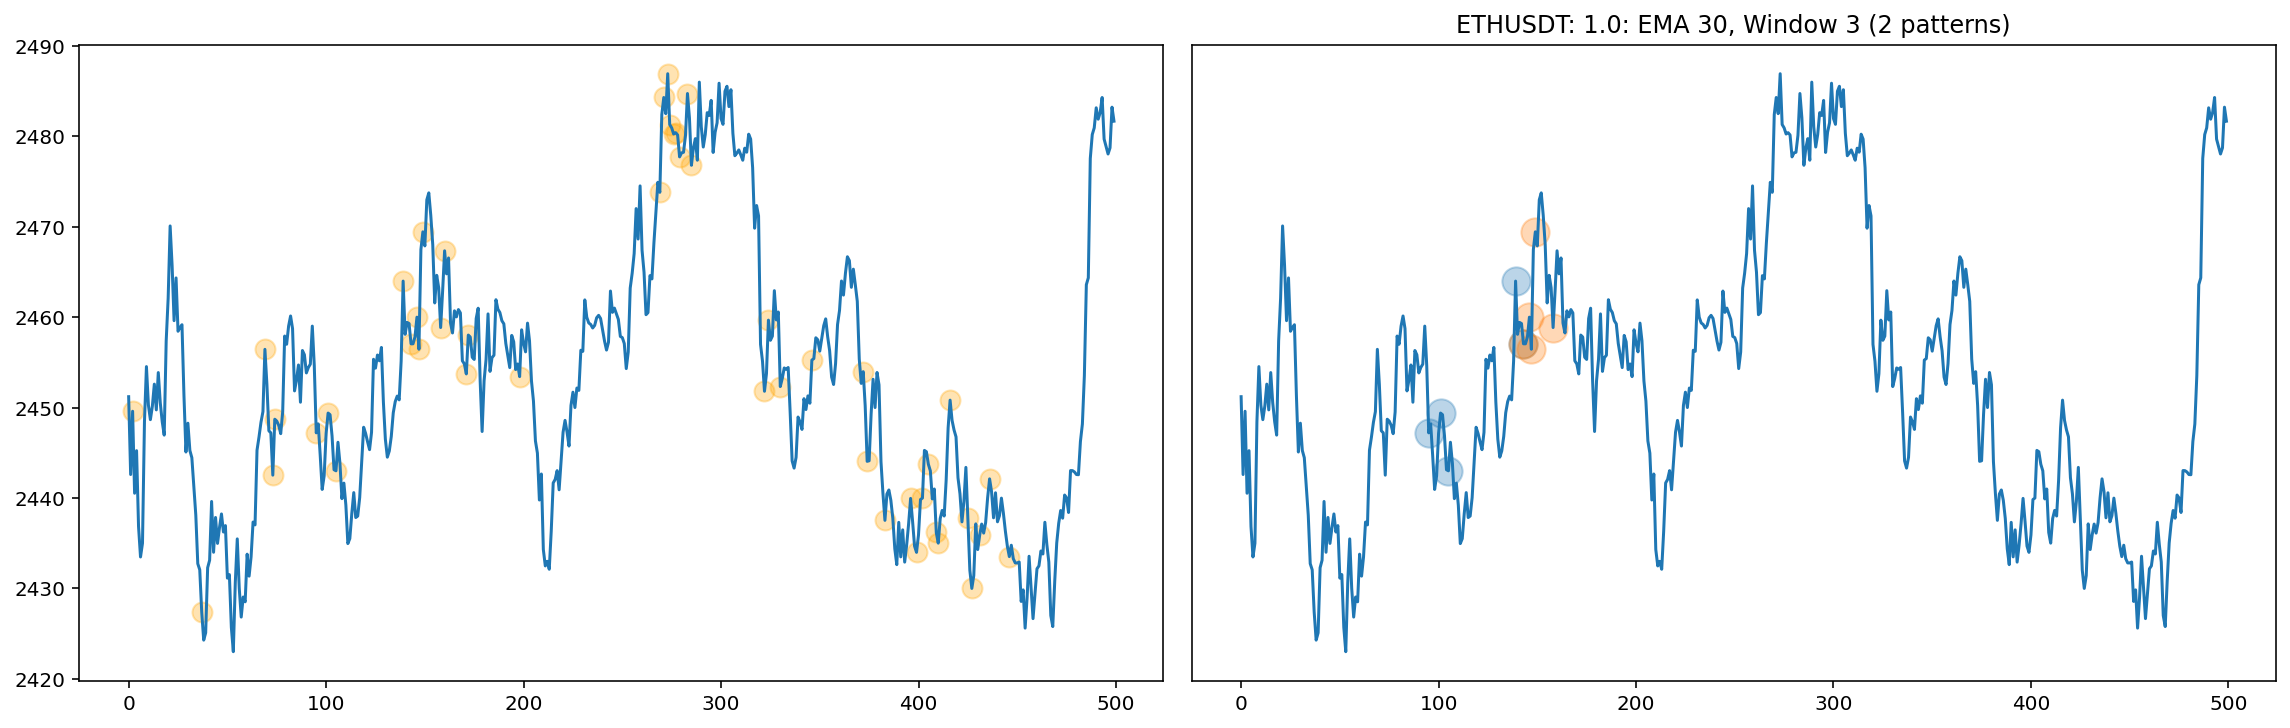

In [94]:
ema_list = [3, 10, 20, 30, ]
window_list = [3, 10, 20, 30, ]
results = screener(resampled_prices, ema_list, window_list, plot=True, results=True)
    


In [99]:
for x in [x for x in results.columns if x not in ['stock', 'date']]:
    results[x] = pd.to_numeric(results[x], errors='coerce')
    
print('Average results by window param')
display(round(results.groupby('window').mean(), 3).sort_values(by=[x for x in results.columns if 'fw' in x], ascending=False))
print('\n', 'Average results by ema param')
display(round(results.groupby('ema').mean(), 3).sort_values(by=[x for x in results.columns if 'fw' in x], ascending=False))
print('\n', 'Average results by stock')
display(round(results.groupby('stock').mean(), 3).sort_values(by=[x for x in results.columns if 'fw' in x], ascending=False))
print('\n', 'Results sorted by return')
display(round(results.sort_values(by=[x for x in results.columns if 'fw' in x], ascending=False), 3))

Average results by window param


,increment,ema,fw_ret_1,fw_ret_12,fw_ret_24,fw_ret_36
window,,,,,,
10,1.0,13.833,0.002,0.002,0.003,0.003
3,1.0,11.938,0.000,0.001,0.002,0.003
20,1.0,15.750,NaN,NaN,NaN,NaN
30,1.0,15.750,NaN,NaN,NaN,NaN



 Average results by ema param


,increment,window,fw_ret_1,fw_ret_12,fw_ret_24,fw_ret_36
ema,,,,,,
10,1.0,11.125,0.001,0.001,0.004,0.006
30,1.0,13.200,0.001,0.000,0.001,-0.002
3,1.0,8.100,0.000,0.001,0.003,0.003
20,1.0,10.286,0.000,0.001,0.000,-0.000



 Average results by stock


,increment,ema,window,fw_ret_1,fw_ret_12,fw_ret_24,fw_ret_36
stock,,,,,,,
ETHUSDT,1.0,13.333,10.267,0.001,0.001,0.002,0.003



 Results sorted by return


,stock,increment,ema,window,date,fw_ret_1,fw_ret_12,fw_ret_24,fw_ret_36
7,ETHUSDT,1.0,3,10,"(242, 269)",0.003,0.002,0.004,0.005
14,ETHUSDT,1.0,10,10,"(171, 198)",0.002,-0.008,-0.002,0.002
2,ETHUSDT,1.0,3,3,"(143, 158)",0.002,-0.002,0.001,-0.000
26,ETHUSDT,1.0,30,3,"(143, 158)",0.002,-0.002,0.001,-0.000
15,ETHUSDT,1.0,10,10,"(231, 265)",0.002,0.007,0.009,0.007
10,ETHUSDT,1.0,10,3,"(9, 43)",0.002,0.001,0.006,0.010
3,ETHUSDT,1.0,3,3,"(198, 218)",0.001,0.006,0.006,0.009
18,ETHUSDT,1.0,20,3,"(74, 105)",0.001,-0.001,0.003,0.007
20,ETHUSDT,1.0,20,3,"(285, 357)",0.001,0.004,-0.003,-0.008
22,ETHUSDT,1.0,20,10,"(285, 357)",0.001,0.004,-0.003,-0.008
